# Nobel prize data analysis

## 1. Objectives

My main aim is to learn more about the prize and what are the contributions to the world that deserve it.  

According to the official [Nobel Prize website](https://www.nobelprize.org/frequently-asked-questions/):

>"The Nobel Prize was set up when businessman and entrepreneur Alfred Nobel died and left the majority of his fortune to the establishment of prizes in physics, chemistry, physiology or medicine, literature and peace. His will stated that the prizes should be awarded to “those who, during the preceding year, shall have conferred the greatest benefit to humankind."

This **field is relevant** because the Nobel prize gets the layman person closer to scientific achievements that otherwise would only find echo in small niches, which in turn sparks curiosity and hopefuly contributes to more children joining stem fields. Not only this but many political leaders and people around the world benefit from encountering this information as it shows how other countries allocate funding to research and how these developments improve the industry and then the economy of those countries.

## 1.1 Questions I want to answer

1. Who was the person that won the most money
2. what category/field gets you closer to win an award (if any)
3. Average number of people awarded per year
4. year or years with the highest number of winners
5. year or years with the lowest number of winners
6. Category of the prize that has given the most money 


# 2. Datasets

I wanted to use one of the [JSON datasets](http://api.nobelprize.org/v1/prize.json) related to the Nobel Prize that we saw in the module 5.12. However this dataset alone didn't include the monetary informaton. So I looked online for other datasets that could complement this gap and I found an interesting one in the official [Nobel Prize website](https://www.nobelprize.org/frequently-asked-questions/) and I ended up using both. Notice that both datasets, none of which had restrictions for reserach use.

First we import the libraries that we'll use (pip installs are commented out so I don't run it when testing the notebook)

In [2]:
#pip install pdfplumber
#!java -version
#pip install tabula-py
#!pip install -q tabula-py
#pip install texlive-xetex
#pip install nbconvert
#pip install pandoc

In [3]:
import pandas as pd
import numpy as np
import requests
import json
import tabula
from bs4 import BeautifulSoup
import requests
import seaborn as sns
import matplotlib.pyplot as plt

### 2.1. Getting JSON data from an API

In this case we use the link to the data to scrap it

In [4]:
def getRequestUrl():
    url = "https://api.nobelprize.org/v1/prize.json"
    return url

In [5]:
def getApiData(requestUrl):
    response = requests.get(requestUrl)
    
    data = json.loads(response.text)
    
    results = data['prizes']
    
    return results

In [6]:
requestUrl = getRequestUrl()
results = getApiData(requestUrl)

Now that we have the data we can take a look at it. It's on the same format that we had in the link, so the next step is to make it a workable dataframe. (seen below as a screenshot, otherwise when I export as PDF it occupy entire pages as it renders the whole dataset)

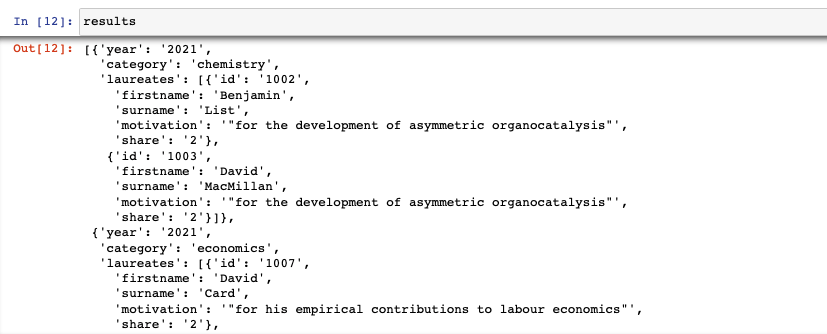

# 3. Data Wrangling

Here we start the process of cleaning our dataset

### 3.1. Creating a dataframe

This step proved to be rather difficult. When I import the data and make it a dataframe object I find that it's not properly parsed. As seen in the table below

In [7]:
df = pd.DataFrame(results)
df.head(2)

,year,category,laureates,overallMotivation
0,2021,chemistry,"[{'id': '1002', 'firstname': 'Benjamin', 'surn...",NaN
1,2021,economics,"[{'id': '1007', 'firstname': 'David', 'surname...",NaN


The problem with the data above is that i'm oly getting the outter level (year, category, laureates) but I'm not able (yet!) to see all the levels including id, firstname, surname, motivation and share


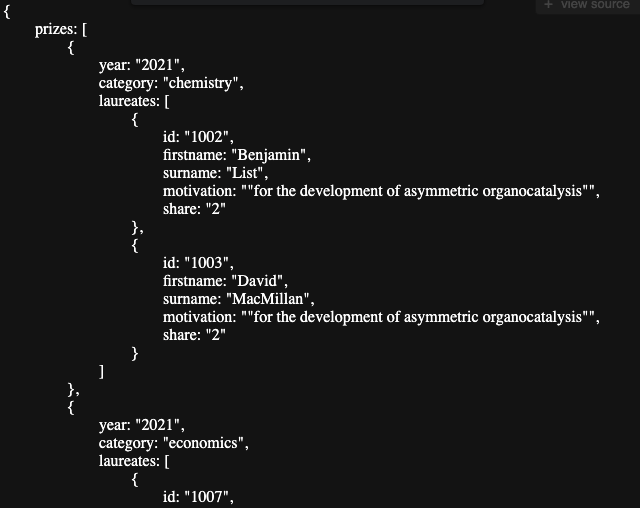



Even normalizing the data doesn't have any effect as shown below.

In [8]:
from pandas import json_normalize

In [9]:
df3 = json_normalize(results)
df3.head(2)

,year,category,laureates,overallMotivation
0,2021,chemistry,"[{'id': '1002', 'firstname': 'Benjamin', 'surn...",NaN
1,2021,economics,"[{'id': '1007', 'firstname': 'David', 'surname...",NaN


After a long search I came across this [custom-built function](https://stackoverflow.com/questions/54756909/not-able-to-flatten-json-file-with-multiple-values) ([user profile](https://stackoverflow.com/users/6817835/gold-cy)) below that allowed me to properly parse the data:

In [10]:
def parse(results):
    for item in results:
        data = pd.DataFrame([{k:v for k, v in item.items() if k != 'laureates'}])
        locs = pd.DataFrame(item.get('laureates'))
        yield pd.concat([data, locs], axis=1).fillna(method='ffill')

df = pd.concat(parse(results), axis=0, ignore_index=True)
df.shape

(1024, 8)

Finally a proper dataset! The custom built function works by separating the column \['laureate'\] from the other columns (year, category, overallMotivation) and saving it in the variable **'locs'**, then saving the other columns in the variable **'data'**, lastly concatenating the two 'different' datasets into one.

From the pandas documentation, [items](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.items.html) works in the following way:

>\[DataFrame.items( )\] Iterates over the DataFrame columns, returning a tuple with the column name and the content as a Series.

This is how we get the result below:

In [11]:
df.head()

,year,category,id,firstname,surname,motivation,share,overallMotivation
0,2021,chemistry,1002,Benjamin,List,"""for the development of asymmetric organocatal...",2,NaN
1,2021,chemistry,1003,David,MacMillan,"""for the development of asymmetric organocatal...",2,NaN
2,2021,economics,1007,David,Card,"""for his empirical contributions to labour eco...",2,NaN
3,2021,economics,1008,Joshua,Angrist,"""for their methodological contributions to the...",4,NaN
4,2021,economics,1009,Guido,Imbens,"""for their methodological contributions to the...",4,NaN


## 3.2. Null values

Now we'll look for null values. Here what I do is to create a column that shows the null values as a percentage from the total dataframe

In [12]:
df_nan = df.isnull().sum().to_frame()

df_nan.columns=['count']
df_nan.reset_index()
df_nan['percentage'] = round(df_nan['count']/df_nan['count'].sum(),2)
df_nan

,count,percentage
year,0,0.00
category,0,0.00
id,49,0.04
firstname,49,0.04
surname,76,0.06
motivation,49,0.04
share,49,0.04
overallMotivation,952,0.78


We see that the column overallMotivation is 78% empty. I'd like to see what these comments are about, so next I'm creating a dataframe the includes the **notnull** values of **overallMotivation**

In [13]:
df_not_null_overallMoti = df[df.overallMotivation.notnull()]
df_not_null_overallMoti

,year,category,id,firstname,surname,motivation,share,overallMotivation
8,2021,physics,999,Syukuro,Manabe,"""for the physical modelling of Earth’s climate...",4,"""for groundbreaking contributions to our under..."
9,2021,physics,1000,Klaus,Hasselmann,"""for the physical modelling of Earth’s climate...",4,"""for groundbreaking contributions to our under..."
10,2021,physics,1001,Giorgio,Parisi,"""for the discovery of the interplay of disorde...",2,"""for groundbreaking contributions to our under..."
33,2019,physics,973,James,Peebles,"""for theoretical discoveries in physical cosmo...",2,"""for contributions to our understanding of the..."
34,2019,physics,974,Michel,Mayor,"""for the discovery of an exoplanet orbiting a ...",4,"""for contributions to our understanding of the..."
...,...,...,...,...,...,...,...,...
933,1916,medicine,NaN,NaN,NaN,NaN,NaN,"""No Nobel Prize was awarded this year. The pri..."
936,1915,peace,NaN,NaN,NaN,NaN,NaN,"""No Nobel Prize was awarded this year. The pri..."
939,1915,medicine,NaN,NaN,NaN,NaN,NaN,"""No Nobel Prize was awarded this year. The pri..."
941,1914,literature,NaN,NaN,NaN,NaN,NaN,"""No Nobel Prize was awarded this year. The pri..."


## 3.3. Motivation vs overallMotivation comments

We have two columns that look very similar but we cannot see the comments as the text is trimmed. I'm going to take a look at them now, as you can see that Pandas normally shows a preview so what I'll doo is to show those two columns.   

As you can see below, the comment for the **motivation** column is more specific as to what the achievement was.

UPDATE: now the dataframe above shows all the text but when I started I had to run the code below to be able to see the whole comment.

In [14]:
df_not_null_overallMoti.loc[337:596,'motivation':'overallMotivation']

,motivation,share,overallMotivation
337,"""for his invention of the polymerase chain rea...",2,"""for contributions to the developments of meth..."
338,"""for his fundamental contributions to the esta...",2,"""for contributions to the developments of meth..."
554,NaN,NaN,"""No Nobel Prize was awarded this year. The pri..."
596,NaN,NaN,"""No Nobel Prize was awarded this year. The pri..."


## 3.4. Imputing missing values

In this case the imputation is straightforward for the following reason:
  
The columns **motivation**, **id**, **firstname**, and **share** have 49 missing values each. These missing values obey to years in which there was no prize given, the reason for which is given in the **overallMotivation** column
  
So I'll perform the imputation as follows:

1. The **share** column NaN values will be replaced with '0', which is the number of people that won the prize that year
2. The **motivation** column NaN values will be imputed directly with the values from the column **overallMotivation**, which explains why there was no prize that year
3. The **id** column NaN values will be left as NaN, I see no reason for imputing them as these are discrete values and we don't need to perform any calculations with them
4. The first and last names columns with NaN will be left as such

After performing these imputations I'll delete the column **overallMotivation** as it's redundant with column **motivation**, with the later offering more detail into the achievements

In [15]:
df1 = df.copy() #I'm creating a copy of the original dataset in order not to modify it.
df1.shape

(1024, 8)

In [16]:
df1['share'] = df1['share'].fillna(value=0) #Here we replace NaN values wiht a 0

#I'm filling "surname" NaN with blank spaces in order not to lose rows that have a firstname but not a surname
#when I combine the two into a single column named "full_name"
df1['surname'] = df1['surname'].fillna(" ") 

Now we confirm that our first imputation worked. As you can see, before the **share** NaN matched the **motivation** NaN but not anymore because **share** now has zeros instead of NaN

In [17]:
df1.loc[df1['id'].isna()]

,year,category,id,firstname,surname,motivation,share,overallMotivation
554,1972,peace,NaN,NaN,,NaN,0,"""No Nobel Prize was awarded this year. The pri..."
596,1967,peace,NaN,NaN,,NaN,0,"""No Nobel Prize was awarded this year. The pri..."
604,1966,peace,NaN,NaN,,NaN,0,"""No Nobel Prize was awarded this year. The pri..."
681,1956,peace,NaN,NaN,,NaN,0,"""No Nobel Prize was awarded this year. The pri..."
690,1955,peace,NaN,NaN,,NaN,0,"""No Nobel Prize was awarded this year. The pri..."
738,1948,peace,NaN,NaN,,NaN,0,"""No Nobel Prize was awarded this year. The pri..."
771,1943,literature,NaN,NaN,,NaN,0,"""No Nobel Prize was awarded this year. The pri..."
772,1943,peace,NaN,NaN,,NaN,0,"""No Nobel Prize was awarded this year. The pri..."
776,1942,chemistry,NaN,NaN,,NaN,0,"""No Nobel Prize was awarded this year. The pri..."
777,1942,literature,NaN,NaN,,NaN,0,"""No Nobel Prize was awarded this year. The pri..."


In [18]:
#looking at how many NaN do I have in the column motivation
print("we have ", df1['motivation'].isnull().sum(), "NaN values in the column 'motivation'")

we have  49 NaN values in the column 'motivation'


In [19]:
#replacing the NaN values in column "motivaiton" with the strings in column "overallMotivation"

df1['motivation'].fillna(df1['overallMotivation'], inplace=True)

In [20]:
#looking at how many NaN do I have in the column motivation AFTER imputation
print("we have ", df1['motivation'].isnull().sum(), "NaN values in the column 'motivation'")

we have  0 NaN values in the column 'motivation'


#### Dropping the overallMotivation column

This column fulfilled its role and now it's time for it to go

In [21]:
df1.drop(columns='overallMotivation', inplace=True)

In [22]:
df1['full_name'] = df1['firstname'] + " " + df1['surname']

In [23]:
df1.drop(['firstname', 'surname'], axis=1, inplace=True)

In [24]:
df1.isnull().sum() #looking again at the null values after imputation

year           0
category       0
id            49
motivation     0
share          0
full_name     49
dtype: int64

our critical columns are **year**, **category**, **motivation**, and **share** and they don't show any NaN values now. So we can proceed.

## 3.5. Our final dataset looks like this and it's ready for some fancy EDA

In [25]:
df1.head()

,year,category,id,motivation,share,full_name
0,2021,chemistry,1002,"""for the development of asymmetric organocatal...",2,Benjamin List
1,2021,chemistry,1003,"""for the development of asymmetric organocatal...",2,David MacMillan
2,2021,economics,1007,"""for his empirical contributions to labour eco...",2,David Card
3,2021,economics,1008,"""for their methodological contributions to the...",4,Joshua Angrist
4,2021,economics,1009,"""for their methodological contributions to the...",4,Guido Imbens


## 3.6 Or is it?... Not so fast!

I'd also like to know how much did these people make in terms of money. Luckily I found a dataset with this information in the official [Nobel Prize website](https://www.nobelprize.org/frequently-asked-questions/), but we'll have to some data wrangling again before we get to the juicy EDA.

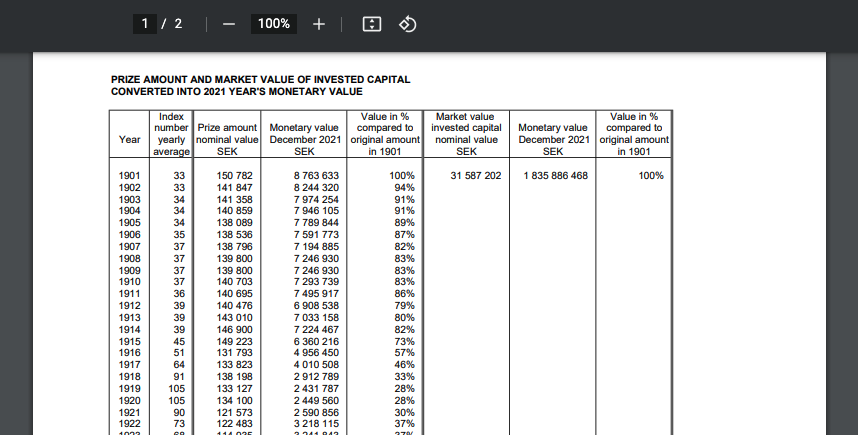

# 3.6.1 Importing the second dataset

In this case I decided to go old school and _download_ the pdf, which I saved in the same folder with this notebook. Below I import the PDF and read all pages (2), however, I found I had to create one dataset for each one and after trying various methods, converting them to csv helped parsing the data.

I then created two csv objects that I then read and contatenate into a single one.

I used the [tabula](https://tabula-py.readthedocs.io/en/latest/) library to read the PDF.

In [26]:
pdf_path = 'prize-amounts-2022.pdf'
df_pdf = tabula.read_pdf(pdf_path, stream=True, pages="all", format='csv') #I used the tabula library for this file
df_pdf[0].to_csv("first_table.csv") #create first csv
df_pdf[1].to_csv("second_table.csv")

In [27]:
df_csv_first = pd.read_csv("first_table.csv")
df_csv_second =pd.read_csv("second_table.csv")
print("The shape of the first dataframe is: ", df_csv_first.shape)
print("The shape of the second dataframe is: ", df_csv_second.shape)

df2 = pd.concat([df_csv_first, df_csv_second], axis=0).fillna(method='ffill')

The shape of the first dataframe is:  (62, 9)
The shape of the second dataframe is:  (66, 9)


In [28]:
df2.dtypes

Unnamed: 0       int64
Unnamed: 0.1    object
Index           object
Unnamed: 1      object
Unnamed: 2      object
Value in %      object
Market value    object
Unnamed: 3      object
Value in %.1    object
dtype: object

## 3.6.2. Fixing the columns of our second dataset

As we can se below using the head() method, the column headers are now split in rows 0,1,2 so we need to find a way to fix them

In [29]:
print(df2.shape)
df2.head(10)

(128, 9)


,Unnamed: 0,Unnamed: 0.1,Index,Unnamed: 1,Unnamed: 2,Value in %,Market value,Unnamed: 3,Value in %.1
0,0,NaN,number,Prize amount,Monetary value,compared to,invested capital,Monetary value,compared to
1,1,Year,yearly,nominal value,December 2021,original amount,nominal value,December 2021,original amount
2,2,Year,average,SEK,SEK,in 1901,SEK,SEK,in 1901
3,3,1901,33,150 782,8 763 633,100%,31 587 202,1 835 886 468,100%
4,4,1902,33,141 847,8 244 320,94%,31 587 202,1 835 886 468,100%
5,5,1903,34,141 358,7 974 254,91%,31 587 202,1 835 886 468,100%
6,6,1904,34,140 859,7 946 105,91%,31 587 202,1 835 886 468,100%
7,7,1905,34,138 089,7 789 844,89%,31 587 202,1 835 886 468,100%
8,8,1906,35,138 536,7 591 773,87%,31 587 202,1 835 886 468,100%
9,9,1907,37,138 796,7 194 885,82%,31 587 202,1 835 886 468,100%


In [30]:
df_pdf = df2.copy()

After much trial and error I finally found how to rename the headers of the PDF file using the data in the first three rows. I spent an entire afternoon in this but I always knew it had to be possible. I never lost faith and I was rewarded. Bear in mind though that my method is not perfect and i had to make maual adjustments (not proud of it) like adding underscores between words to make them more readable and changing the names of the first two columns (from '3' to 'col_index' and for 'nan' to 'year'

[These people](https://datascientyst.com/convert-first-row-header-column-pandas-dataframe/) are heroes. I adapted this code to take the first three rows (adding strings '+') and drop those very same rows from the dataframe ('.drop'). I find it interesting and satisfying to some degree that before finding this bit of code I took a break to breath fresh air and think about the problem and in mi mind I realised the solution should include some sort of iloc iteration and string contatenation, so in part I was close to the solution but I don't think I would've been able to come up with the 'drop' part of the code on my own.



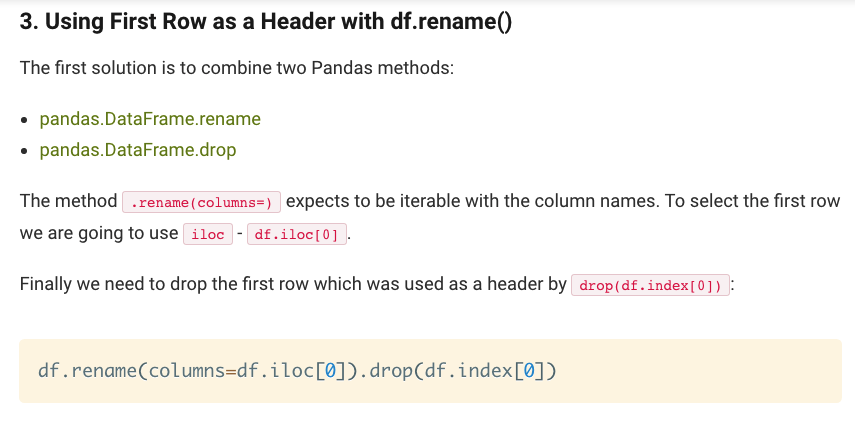

In [31]:
df_pdf = df_pdf.rename(columns=df_pdf.iloc[0]+df_pdf.iloc[1]+df_pdf.iloc[2]).drop(df_pdf.index[0:3])

In [32]:
df_pdf.columns

Index([                                  3,
                                       nan,
                     'numberyearlyaverage',
            'Prize amountnominal valueSEK',
          'Monetary valueDecember 2021SEK',
       'compared tooriginal amountin 1901',
        'invested capitalnominal valueSEK',
          'Monetary valueDecember 2021SEK',
       'compared tooriginal amountin 1901'],
      dtype='object')

In [33]:
df_pdf.columns = ['col_index','year','index_number_yearly_average','Prize_amountnominal_value_SEK',
          'Monetary_value_December_2021_SEK','compared_to_original_amount_in_1901',
        'invested_capital_nominal_value_SEK','2_Monetary_value_December_2021_SEK','compared_to_original_amount_in_1901']

In [34]:
df_pdf.drop(columns='col_index', axis=1, inplace=True) #droping the duplicated index column (formerly known as '3')

Below we can see our new dataset with proper columns in it

In [35]:
df_pdf.head(3)

,year,index_number_yearly_average,Prize_amountnominal_value_SEK,Monetary_value_December_2021_SEK,compared_to_original_amount_in_1901,invested_capital_nominal_value_SEK,2_Monetary_value_December_2021_SEK,compared_to_original_amount_in_1901
3,1901,33,150 782,8 763 633,100%,31 587 202,1 835 886 468,100%
4,1902,33,141 847,8 244 320,94%,31 587 202,1 835 886 468,100%
5,1903,34,141 358,7 974 254,91%,31 587 202,1 835 886 468,100%


Now using the describe method we confirm that Pandas is reading the columns as numbers:

In [36]:
df_pdf.describe()

,year,index_number_yearly_average,Prize_amountnominal_value_SEK,Monetary_value_December_2021_SEK,compared_to_original_amount_in_1901,invested_capital_nominal_value_SEK,2_Monetary_value_December_2021_SEK,compared_to_original_amount_in_1901
count,122,122,122,122,122,122,122,122
unique,122,100,101,120,67,48,49,47
top,1907,37,10 000 000,10 000 000,34%,31 587 202,1 835 886 468,100%
freq,1,4,14,2,7,59,59,59


And we don't have empty values. Life couldn't be beter.

In [37]:
print(df_pdf.shape)
df_pdf.isnull().sum()

(122, 8)


year                                   0
index_number_yearly_average            0
Prize_amountnominal_value_SEK          0
Monetary_value_December_2021_SEK       0
compared_to_original_amount_in_1901    0
invested_capital_nominal_value_SEK     0
2_Monetary_value_December_2021_SEK     0
compared_to_original_amount_in_1901    0
dtype: int64

## 3.6.3. Dropping unnecessary columns

i want to keep it simple and look at the amount of money given the year the prize was awarded and it's equivalent value in December 2021 in dollars; the currency in the dataset is Swedish Krones (SEK). This means working with the first three columns only and removing the last three that make reference to market value of the monetary prize at the year of the event and in December 2021

In [38]:
df_pdf_2 = df_pdf[['year', 'Prize_amountnominal_value_SEK', 'Monetary_value_December_2021_SEK']]
df_pdf_2.head()

,year,Prize_amountnominal_value_SEK,Monetary_value_December_2021_SEK
3,1901,150 782,8 763 633
4,1902,141 847,8 244 320
5,1903,141 358,7 974 254
6,1904,140 859,7 946 105
7,1905,138 089,7 789 844


# 4. Last steps in data wrangling and a *final dataset to rule them all*

So we have two clean datasets, now we need to **merge them** to make a single one.

In [39]:
print("shape of our first dataset is: ", df1.shape)
print("shape of our second dataset is: ", df_pdf_2.shape)

shape of our first dataset is:  (1024, 6)
shape of our second dataset is:  (122, 3)


In [40]:
df_nobel = pd.merge(df1, 
                      df_pdf_2, 
                      on ='year', 
                      how ='outer') #performing an outer join beacuse I'm using the year as key
df_nobel.shape

(1025, 8)

I noticed that in the tail there was this bit with NaN, it comes from one of the tables so we're going to slice the dataframe to remove it

In [41]:
df_nobel.tail(2)#a sneak peak into the new dataset

,year,category,id,motivation,share,full_name,Prize_amountnominal_value_SEK,Monetary_value_December_2021_SEK
1023,1901,medicine,293,"""for his work on serum therapy, especially its...",1,Emil von Behring,150 782,8 763 633
1024,Dec,NaN,NaN,NaN,NaN,NaN,10 000 000,10 000 000


In [42]:
df_nobel = df_nobel[:-1] #selecting everything BUT the last row with "year": Dec
df_nobel.shape

(1024, 8)

In [43]:
df_nobel.tail(2) #It worked

,year,category,id,motivation,share,full_name,Prize_amountnominal_value_SEK,Monetary_value_December_2021_SEK
1022,1901,physics,1,"""in recognition of the extraordinary services ...",1,Wilhelm Conrad Röntgen,150 782,8 763 633
1023,1901,medicine,293,"""for his work on serum therapy, especially its...",1,Emil von Behring,150 782,8 763 633


Now we look for empty values: everything's in order

In [44]:
df_nobel.isnull().sum()

year                                 0
category                             0
id                                  49
motivation                           0
share                                0
full_name                           49
Prize_amountnominal_value_SEK        0
Monetary_value_December_2021_SEK     0
dtype: int64

# 5. Basic feature engineering

1. The currency is is SEK (Swedish Krone) so I'll add a column that shows the value in dollars, but will preserve the original column as I want to preserve the original information in case anyone is interested.   
   

2. Share column shows the number of people that won the prize in any given year, I want to create a column that shows how much money did each person win

1. for the USD conversion I'll use the exchange rate at Jun 2022 **1 SEK = USD 0.099**

In [45]:
df_nobel.dtypes

year                                object
category                            object
id                                  object
motivation                          object
share                               object
full_name                           object
Prize_amountnominal_value_SEK       object
Monetary_value_December_2021_SEK    object
dtype: object

So, i tried multypling the column **Monetary_value_December_2021_SEK** by its dollar exchange (0,099) however I got an error "TypeError: can't multiply sequence by non-int of type 'float'". Then I tried many different ways of converting the column type from object to int or float to no avail. Then i tried regex to remove the spaces in the columns (i.e., 10 000 000) which I thought were causing the problem but this proved to be futile as well.

In [46]:
#testing the string addition to see if it works and it does
df_nobel['USD'] = df_nobel['Prize_amountnominal_value_SEK'] + df_nobel['Prize_amountnominal_value_SEK']

In [47]:
df_nobel.head() #testing string addition (column USD)

,year,category,id,motivation,share,full_name,Prize_amountnominal_value_SEK,Monetary_value_December_2021_SEK,USD
0,2021,chemistry,1002,"""for the development of asymmetric organocatal...",2,Benjamin List,10 000 000,10 000 000,10 000 00010 000 000
1,2021,chemistry,1003,"""for the development of asymmetric organocatal...",2,David MacMillan,10 000 000,10 000 000,10 000 00010 000 000
2,2021,economics,1007,"""for his empirical contributions to labour eco...",2,David Card,10 000 000,10 000 000,10 000 00010 000 000
3,2021,economics,1008,"""for their methodological contributions to the...",4,Joshua Angrist,10 000 000,10 000 000,10 000 00010 000 000
4,2021,economics,1009,"""for their methodological contributions to the...",4,Guido Imbens,10 000 000,10 000 000,10 000 00010 000 000


I was able to finally find [this code](https://stackoverflow.com/questions/41476150/removing-space-from-columns-in-pandas) that allowed me to remove the spaces "everywhere" and after that transforming the data from the column USD into int was easier as I have examples of this code in another notebook of mine

>df.columns = df.columns.str.replace(' ', '')

In [48]:
#testing if i can convert this column to int
df_nobel['share'] = df_nobel['share'].astype(str).astype(int)

In [49]:
#removing spaces in the numbers
df_nobel['USD'] = df_nobel.USD.str.replace(' ', '')
df_nobel['Prize_amountnominal_value_SEK'] = df_nobel.Prize_amountnominal_value_SEK.str.replace(' ', '')
df_nobel['Monetary_value_December_2021_SEK'] = df_nobel.Monetary_value_December_2021_SEK.str.replace(' ', '')

In [50]:
#finally converting the columns to int

df_nobel['USD'] = df_nobel['USD'].astype(str).astype(int)
df_nobel['Prize_amountnominal_value_SEK'] = df_nobel['Prize_amountnominal_value_SEK'].astype(str).astype(int)
df_nobel['Monetary_value_December_2021_SEK'] = df_nobel['Monetary_value_December_2021_SEK'].astype(str).astype(int)

In [51]:
df_nobel.head(2)

,year,category,id,motivation,share,full_name,Prize_amountnominal_value_SEK,Monetary_value_December_2021_SEK,USD
0,2021,chemistry,1002,"""for the development of asymmetric organocatal...",2,Benjamin List,10000000,10000000,1000000010000000
1,2021,chemistry,1003,"""for the development of asymmetric organocatal...",2,David MacMillan,10000000,10000000,1000000010000000


In [52]:
df_nobel.dtypes #It worked!

year                                object
category                            object
id                                  object
motivation                          object
share                                int64
full_name                           object
Prize_amountnominal_value_SEK        int64
Monetary_value_December_2021_SEK     int64
USD                                  int64
dtype: object

Back to square one-

1. I'll create a column that will have the dollar rate
2. I'll create a column that will show how many (in dollars) was given to each winner in a given year

In [53]:
df_nobel['USD'] = df_nobel['Monetary_value_December_2021_SEK'] * 0.099

#I'm adding a conditional statement when the "share" value is 0 becaues otherwise the result is "inf"

df_nobel['prize_per_person'] = round(df_nobel['USD'] / df_nobel['share'])

In [54]:
df_nobel.replace([np.inf, -np.inf], 0, inplace=True)

In [55]:
df_nobel.tail(2)

,year,category,id,motivation,share,full_name,Prize_amountnominal_value_SEK,Monetary_value_December_2021_SEK,USD,prize_per_person
1022,1901,physics,1,"""in recognition of the extraordinary services ...",1,Wilhelm Conrad Röntgen,150782,8763633,867599.667,867600.0
1023,1901,medicine,293,"""for his work on serum therapy, especially its...",1,Emil von Behring,150782,8763633,867599.667,867600.0


In [56]:
df_nobel = df_nobel.sort_values("year")

# 6. Show me the money!

Here we look first at the value of the prize through the years in local currency (SEK). It's normal to see this growth in time but it's interesting also that from 2001 to 2011 and in 2021 the amount is the same

<Figure size 504x288 with 0 Axes>

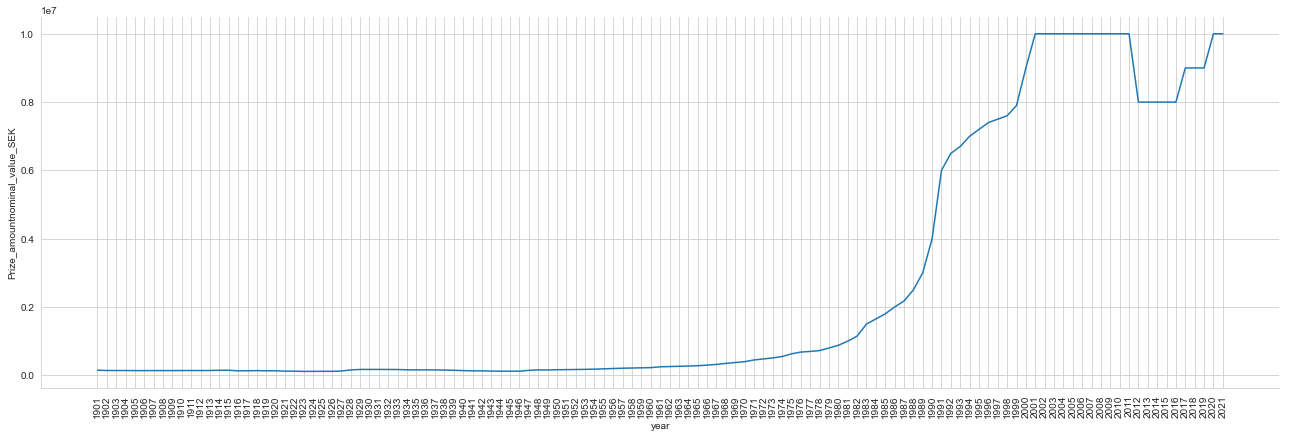

In [57]:
plt.figure(figsize=(7,4))
sns.set_style("whitegrid")

g = sns.FacetGrid(data=df_nobel, height=6, aspect=3)
g.map(sns.lineplot, "year","Prize_amountnominal_value_SEK", ci=None)
g.add_legend()
g.set_xticklabels(rotation=90)

Below we look at the value of the prize converted to USD in 2021 through the years. As we can see here 2001 had the highest value and 1919 the lowest

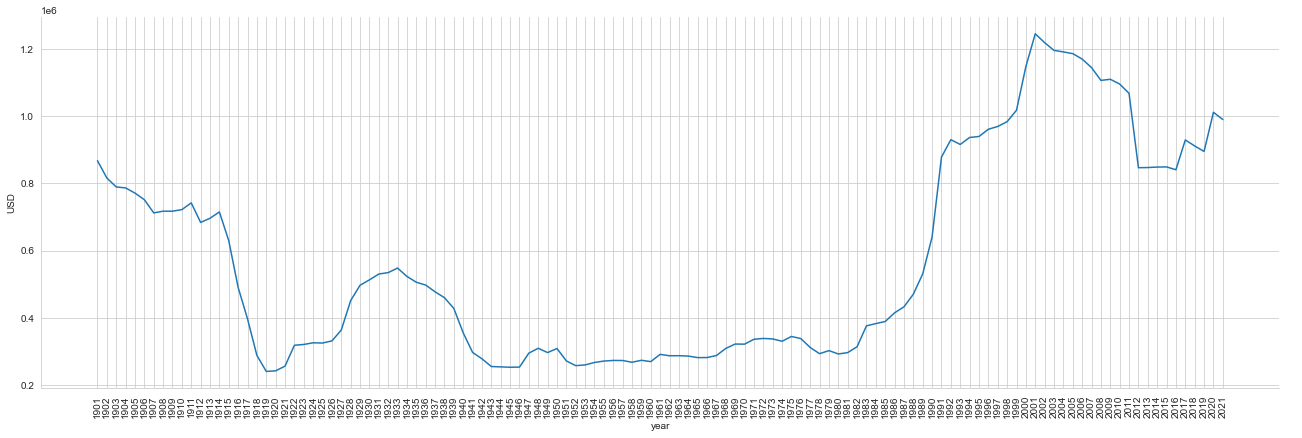

In [58]:
g = sns.FacetGrid(data=df_nobel, height=6, aspect=3)
g.map(sns.lineplot, "year","USD", ci=None)
g.add_legend()
g.set_xticklabels(rotation=90)

In [59]:
#I wanted to take a look at the max values. Not sure how it determines the "max string" but I found out who
#Gunter Grass was due to this and that's a good thing.

df_nobel.max()

year                                                                             2021
category                                                                      physics
motivation                          "whose frolicsome black fables portray the for...
share                                                                               4
Prize_amountnominal_value_SEK                                                10000000
Monetary_value_December_2021_SEK                                             12577049
USD                                                                       1245127.851
prize_per_person                                                            1245128.0
dtype: object

Now we filter the dataset to show the rows with the highest money prize. **All the max prizes were given in 2001.**

In [60]:
max_value = df_nobel['USD'].max()

df_nobel.loc[df_nobel['USD'] == max_value]

,year,category,id,motivation,share,full_name,Prize_amountnominal_value_SEK,Monetary_value_December_2021_SEK,USD,prize_per_person
241,2001,chemistry,741,"""for their work on chirally catalysed hydrogen...",4,William Knowles,10000000,12577049,1245127.851,311282.0
246,2001,economics,746,"""for their analyses of markets with asymmetric...",3,Joseph E. Stiglitz,10000000,12577049,1245127.851,415043.0
242,2001,chemistry,742,"""for their work on chirally catalysed hydrogen...",4,Ryoji Noyori,10000000,12577049,1245127.851,311282.0
243,2001,chemistry,743,"""for his work on chirally catalysed oxidation ...",2,Barry Sharpless,10000000,12577049,1245127.851,622564.0
244,2001,economics,744,"""for their analyses of markets with asymmetric...",3,George A. Akerlof,10000000,12577049,1245127.851,415043.0
245,2001,economics,745,"""for their analyses of markets with asymmetric...",3,A. Michael Spence,10000000,12577049,1245127.851,415043.0
247,2001,literature,747,"""for having united perceptive narrative and in...",1,V. S. Naipaul,10000000,12577049,1245127.851,1245128.0
254,2001,medicine,735,"""for their discoveries of key regulators of th...",3,Leland Hartwell,10000000,12577049,1245127.851,415043.0
249,2001,peace,749,"""for their work for a better organized and mor...",2,Kofi Annan,10000000,12577049,1245127.851,622564.0
250,2001,physics,738,"""for the achievement of Bose-Einstein condensa...",3,Eric Cornell,10000000,12577049,1245127.851,415043.0


The year 1919 was the one with the lowest amount of money out of the years in which the ceremony took place. In this year there was no prize awarded to the category "chemistry"

In [61]:
min_value = df_nobel['USD'].min()

df_nobel.loc[df_nobel['USD'] == min_value]

,year,category,id,motivation,share,full_name,Prize_amountnominal_value_SEK,Monetary_value_December_2021_SEK,USD,prize_per_person
917,1919,medicine,309,"""for his discoveries relating to immunity""",1,Jules Bordet,133127,2431787,240746.913,240747.0
916,1919,physics,24,"""for his discovery of the Doppler effect in ca...",1,Johannes Stark,133127,2431787,240746.913,240747.0
915,1919,peace,483,"""for his role as founder of the League of Nati...",1,Woodrow Wilson,133127,2431787,240746.913,240747.0
914,1919,literature,588,"""in special appreciation of his epic, <I>Olymp...",1,Carl Spitteler,133127,2431787,240746.913,240747.0
913,1919,chemistry,NaN,"""No Nobel Prize was awarded this year. The pri...",0,NaN,133127,2431787,240746.913,0.0


In [62]:
df_nobel.loc[df_nobel['share'] == 0]

,year,category,id,motivation,share,full_name,Prize_amountnominal_value_SEK,Monetary_value_December_2021_SEK,USD,prize_per_person
942,1914,peace,NaN,"""No Nobel Prize was awarded this year. The pri...",0,NaN,146900,7224467,715222.233,0.0
941,1914,literature,NaN,"""No Nobel Prize was awarded this year. The pri...",0,NaN,146900,7224467,715222.233,0.0
939,1915,medicine,NaN,"""No Nobel Prize was awarded this year. The pri...",0,NaN,149223,6360216,629661.384,0.0
936,1915,peace,NaN,"""No Nobel Prize was awarded this year. The pri...",0,NaN,149223,6360216,629661.384,0.0
933,1916,medicine,NaN,"""No Nobel Prize was awarded this year. The pri...",0,NaN,131793,4956450,490688.550,0.0
932,1916,physics,NaN,"""No Nobel Prize was awarded this year. The pri...",0,NaN,131793,4956450,490688.550,0.0
931,1916,peace,NaN,"""No Nobel Prize was awarded this year. The pri...",0,NaN,131793,4956450,490688.550,0.0
929,1916,chemistry,NaN,"""No Nobel Prize was awarded this year. The pri...",0,NaN,131793,4956450,490688.550,0.0
923,1917,chemistry,NaN,"""No Nobel Prize was awarded this year. The pri...",0,NaN,133823,4010508,397040.292,0.0
928,1917,medicine,NaN,"""No Nobel Prize was awarded this year. The pri...",0,NaN,133823,4010508,397040.292,0.0


# 7. Answering our research questions

1. Who was the person that won the most money
2. what category/field gets you closer to win an award (if any)
3. Average number of people awarded per year
4. year or years with the highest number of winners
5. year or years with the lowest number of winners
6. Category of the prize that has received the most money
8. Total money awarded in each category since the inception of the award
9. Total money awarded since the inception of the award
10. Year in which the most money was awarded

### 1. Who was the person that won the most money

In [63]:
max_prize_per_person = df_nobel['prize_per_person'].max()
x = df_nobel.loc[df_nobel['prize_per_person'] == max_prize_per_person]
x

,year,category,id,motivation,share,full_name,Prize_amountnominal_value_SEK,Monetary_value_December_2021_SEK,USD,prize_per_person
247,2001,literature,747,"""for having united perceptive narrative and in...",1,V. S. Naipaul,10000000,12577049,1245127.851,1245128.0


In [64]:
print("The person that has won the most money is", x['full_name'], "in the field: ", x['category'])

The person that has won the most money is 247    V. S. Naipaul
Name: full_name, dtype: object in the field:  247    literature
Name: category, dtype: object


### 2. What category/field gets you closer to win an award (if any)
#### AKA number of prizes per category

The answer to this question is: **medicine, with 233 awards**, followed by physics.


To this day i still find it completely bonkers that the [seaborn documentation](https://seaborn.pydata.org/tutorial/categorical.html#categorical-tutorial) doesn't show how to add labels to your plots.

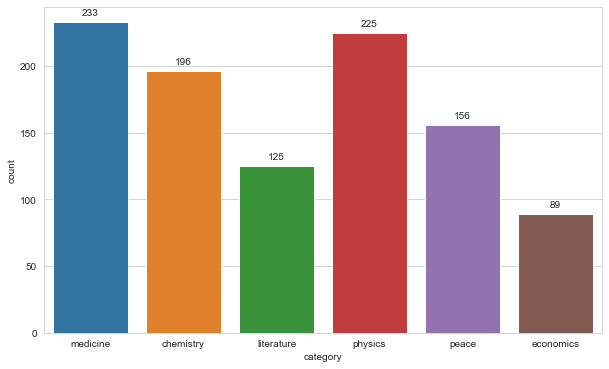

In [65]:
fig = plt.figure(figsize=(10,6))
ax = sns.countplot(x="category", data=df_nobel)

# label each bar in barplot
for p in ax.patches:
    height = p.get_height()
    ax.text(x = p.get_x()+(p.get_width()/2), y = height+5, s = '{:.0f}'.format(height), ha = 'center')

### 3. Average number of people awarded per year

I'm going to create a dataset with the value counts from the column year and then plot it. I have to reset the index and then rename the columns for this to work.

In [66]:
ppl_per_year = df_nobel['year'].value_counts().to_frame()
ppl_per_year = ppl_per_year.reset_index()
ppl_per_year.columns = ['year', 'count']

In [67]:
#otherwise it will order the plot by count instead of year
ppl_per_year = ppl_per_year.sort_values("year")

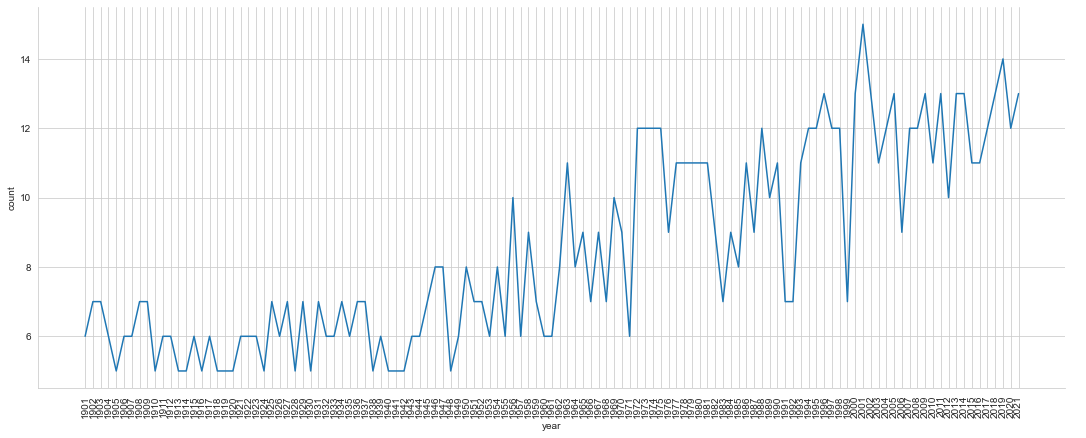

In [68]:
g = sns.FacetGrid(data=ppl_per_year, height=6, aspect=2.5)
g.map(sns.lineplot, "year","count", ci=None)
g.add_legend()
g.set_xticklabels(rotation=90)

In [69]:
max_people = ppl_per_year['count'].max()
min_people = ppl_per_year['count'].min()

print("average number of winners per year is: ", round(ppl_per_year['count'].mean()))
print("\n")
print("year with the highest number of winners: \n", ppl_per_year.loc[ppl_per_year['count'] == max_people])
print("\n")
print("years in with the lowest number of winners: \n", ppl_per_year.loc[ppl_per_year['count'] == min_people])

average number of winners per year is:  8


year with the highest number of winners: 
    year  count
0  2001     15


years in with the lowest number of winners: 
      year  count
113  1905      5
117  1910      5
105  1913      5
108  1914      5
111  1916      5
107  1918      5
106  1919      5
120  1920      5
114  1924      5
115  1928      5
118  1930      5
119  1938      5
116  1940      5
110  1941      5
109  1942      5
112  1948      5


### 6. Category of the prize that has received the most money
### and
### 7. Total money awarded in each category since the inception of the award


For this i'm just going to use groupby()

In [70]:
df_category = df_nobel.groupby(['category']).sum()

In [71]:
pd.options.display.float_format = '{:20,.2f}'.format #format the whole thing to make USD more readable.

In [72]:
df_category.sort_values("USD", ascending=False)

,share,Prize_amountnominal_value_SEK,Monetary_value_December_2021_SEK,USD,prize_per_person
category,,,,,
physics,519,786760492,1411430668,"139,731,636.13","66,174,506.00"
medicine,534,724175798,1369193206,"135,550,127.39","65,331,549.00"
chemistry,396,708875169,1247433267,"123,495,893.43","65,716,389.00"
peace,211,452184847,947029294,"93,755,900.11","61,515,267.00"
economics,178,562891000,723418198,"71,618,401.60","39,502,531.00"
literature,126,310252765,711578370,"70,446,258.63","65,954,018.00"


The winner above is **Physics** with the more money received. We also found that the category with the least amount of money received is **literature**.

### 8. Total money awarded since the inception of the award

In [73]:
print("The total amount of money awarded since the inception of the award is: " '{:20,.2f}'.format(round(df_category['USD'].sum())), "USD")


The total amount of money awarded since the inception of the award is:       634,598,217.00 USD


### 9. Year in which the most money was awarded

For this I'm going to group by year, reset the index so that i can use it as a dataframe and then leave only year and USD. Then I'll just take the max USD value

In [74]:
df_year = df_nobel.groupby(['year']).sum()
df_year.reset_index(inplace=True)

In [75]:
df_year = df_year[['year', 'USD']]

In [76]:
max_USD_per_year = df_year.USD.max()

print("year with the most money awarded: \n", df_year.loc[df_year.USD == max_USD_per_year])

year with the most money awarded: 
      year                  USD
100  2001        18,676,917.77


# Conclusions


1. We were able to answer all the questions we had with the data we found.
2. I think a limitation of the data is that it doesn't contain the gender of the winners; it would've been nice to get some insights on the matter
3. Age of the winner would've been an interesting feature to have
4. Nationality of the winner would've been an interesting featute to have
5. The data wrangling was the hardest part, as working with data from the web proved to be tricky compare to pristine CSVs